
<center>
<img src="https://drive.google.com/uc?id=1rTbXPdOeMzVexXG-5tCDzpxBqa4k21cw" width=200px/>
<center/>

**PATCH CAMELYON CHALLENGE** 

MU4RBI07 Image Processing - Project 

<center>
<img src="https://drive.google.com/uc?id=1Ck5To_hIEpOq9tt1sXgtwe3aSz5-YYFT" width=500px/>
<center/>

---


*PICHON Fabien$^1$, DUSSARD Bastien$^2$, SIMON Louis$^3$*, Master 1 ISI, Sorbonne Université

$^1$ fabien.pichon92700@gmail.com, $^2$ dussardbastien@hotmail.fr, $^3$ louis.simoon@gmail.com


This notebook gathers code and information about our contribution to the *Patch Camelyon* Challenge (https://patchcamelyon.grand-challenge.org/Introduction/).

The PatchCamelyon benchmark gathers hundreds of thousand image of lymph sentinel nodes. The goal here is to detect the precense or the absence of metastatic tissue to help doctors to provide the best drugs for cancer treatment.

The dataset is made of $96\times 96$ patches which allows fast training of complex ML models such as CNNs.

In this notebook, we will present different approaches; one CNN-based and a texture-based.

# CNN

The first approach combines a classical CNN architecture for classification as well as explainability models, namely *LIME* and *Shap*.The aim here is to reach top AUC and accuracy and generate interpretable data for experts.

Training such a model requires a lot of data ($\simeq$1,100,000 trainable parameters) but the number of layers is inferior compared to *state-of-art* architectures such as *GoogLeNet* or *VGG16/19*.

In [1]:
#Uncomment these lines to install the necessary libraries
!pip install tensorflow_datasets
!pip install lime
!pip install tensorflow
!pip install tensorflow.io
!pip install shap

import numpy as np
import matplotlib.pyplot as plt

from google.colab import files

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, classification_report, roc_auc_score
import pickle
from skimage import color

import lime
import shap

     |████████████████████████████████| 276kB 12.1MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=84c73846a1d79aae8d1902403fef8efc1febfea80f127d23c1fee507cc3b0c1d
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 24.1MB 10.8MB/s 
     |████████████████████████████████| 454.3MB 42kB/s 
     |████████████████████████████████| 2.5MB 30.8MB/s 
     |████████████████████████████████| 471kB 40.4MB/s 
     |████████████████████████████████| 4.0MB 31.6MB/s 
     |████████████████████████████████| 6.0MB 61.5MB/s 
     |████████████████████████████████| 1.2MB 28.6MB/s 
     |████████████████████████████████| 4.0MB 36.5MB/s 
     |████████████████████████████████| 4.9MB 27.8MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4

Data loading (around 6 min)

In [ ]:
uploaded = files.upload()

Saving explainerData.npy to explainerData.npy
Saving model_accuracy_0.86.h5 to model_accuracy_0.86.h5
Saving model16_AUC85.pkl to model16_AUC85.pkl
Saving README.txt to README.txt
Saving utilitiesGabor.py to utilitiesGabor.py
Saving X_test_50.npy to X_test_50.npy




```
X_train = tfio.IODataset.from_hdf5(path+'camelyonpatch_level_2_split_train_x.h5', dataset='/x')
y_train = tfio.IODataset.from_hdf5(path+'camelyonpatch_level_2_split_train_y.h5', dataset='/y')

print("Success reading training files")

X_test = tfio.IODataset.from_hdf5(path+'camelyonpatch_level_2_split_test_x.h5', dataset='/x')
y_test = tfio.IODataset.from_hdf5(path+'camelyonpatch_level_2_split_test_y.h5', dataset='/y')

print("Success reading testing files")

#convert the training data from tf.tensor to numpy float32 to the display of images 
#with plt.imshow(X_test[i]) (but requires a lot of time to be processed and isn't really useful)

#X_train2 = list(map(lambda x: (x/255).numpy().astype("float32"), X_train))
#y_train2 = list(map(lambda x: int(x[0][0]), y_train))
#print("Success converting training files")

#convert the testing data
X_test2 = list(map(lambda x: (x/255).numpy().astype("float32"), X_test))
y_test2 = list(map(lambda x: int(x[0][0]), y_test)) 
print("Success converting testing files")
```



In [ ]:
X_test_50 = np.load("X_test_50.npy")
y_test_50 = np.load('y_test1Full.npy')[:50]
X_train_shap = np.load("X_train_shap.npy")

<img src="https://drive.google.com/uc?id=1hwlkvkHk6pTe3nPF9PuEWRc-JZBdXXth" width=1800/>



In [ ]:
#Load the model and print its summary
#path2="C:\\Users\\dussa\\Université\\M1\\S2\\Traitement de l'Image et du Son\Traitement de l'Image\Projet\Projet_Pcam\Models"
model=tf.keras.models.load_model('model_accuracy_0.86.h5')
print("Success loading the saved model")
model.summary()

Success loading the saved model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 94, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 

<img src="https://drive.google.com/uc?id=1THP9aFk9_2cXFva8t3M4GFvxEs3AKhrg" width=400/>

In [ ]:
#we predict the classes of the testing data
y=np.argmax(model.predict([X_test_50]),axis=1)
print("Success computing the predictions")
print("Accuracy = ",accuracy_score(y_test_50,y))
print("AUC = ",roc_auc_score(y_test_50,model.predict(X_test_50)[:,1]))



Success computing the predictions
Accuracy =  0.86
AUC =  0.9485294117647058


In [ ]:
def Explain_Image_Lime(index, label_exp=0):
    import matplotlib.patches as mpatches
    from lime import lime_image
    from skimage.segmentation import mark_boundaries

    explainer=lime_image.LimeImageExplainer(verbose=True)
    print("Image = n°",index," Model output : ")
    exp=explainer.explain_instance(X_test_50[index], classifier_fn=model.predict, hide_color= False)
    img, mask =exp.get_image_and_mask(label=label_exp, hide_rest=False, positive_only=False)
    plt.subplot(1,2,1)
    plt.imshow(X_test_50[index])
    plt.title('Original Image')
    plt.subplot(1,2,2)
    plt.imshow(mark_boundaries(img / 2 + 0.5,mask))
    plt.title('Lime Explanation')
    y_pred=np.argmax(y,axis=-1) # on prend l'arg max de chacun pour avoir les classes prédites vu que c'est encodé en one hot
    print('\n'+"Ground Truth = ",y_test_50[index])
    print("Predicted Class = ",y_pred)
    if label_exp==0:
        print("Image label to explain = ",label_exp,'\n'+"=> green = Area increasing the probability to be classified as nonmetastatic"+'\n'+"=> red = Area decreasing the probability to be classified as nonmetastatic")
    else:
        print("Image label to explain = ",label_exp,'\n'+"=> green = Area increasing the probability to be classified as metastatic"+'\n'+"=> red = Area decreasing the probability to be classified as metastatic")

Image = n° 2  Model output : 



Intercept 0.819616718914377
Prediction_local [0.26731985]
Right: 0.078336395
Intercept 0.18038326060120075
Prediction_local [0.73268015]
Right: 0.9216636

Ground Truth =  0.0
Predicted Class =  1
Image label to explain =  1 
=> green = Area increasing the probability to be classified as metastatic
=> red = Area decreasing the probability to be classified as metastatic


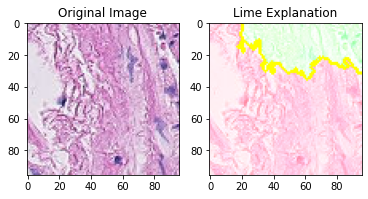

In [ ]:
#TN
Explain_Image_Lime(2,1)

Image = n° 15  Model output : 



Intercept 0.2147172920636726
Prediction_local [0.39784075]
Right: 0.31978476
Intercept 0.7852826840153773
Prediction_local [0.60215926]
Right: 0.6802153

Ground Truth =  1.0
Predicted Class =  1
Image label to explain =  0 
=> green = Area increasing the probability to be classified as nonmetastatic
=> red = Area decreasing the probability to be classified as nonmetastatic


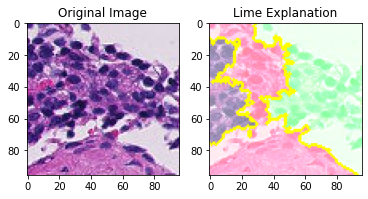

In [ ]:
#FN
Explain_Image_Lime(15,0)

Image = n° 26  Model output : 



Intercept 0.4327613234418277
Prediction_local [-0.01895023]
Right: 0.024326332
Intercept 0.5672386868782824
Prediction_local [1.01895022]
Right: 0.9756737

Ground Truth =  1.0
Predicted Class =  1
Image label to explain =  0 
=> green = Area increasing the probability to be classified as nonmetastatic
=> red = Area decreasing the probability to be classified as nonmetastatic


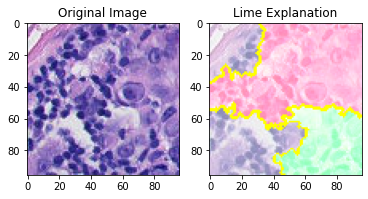

In [ ]:
#TP
Explain_Image_Lime(26,0)

Image = n° 22  Model output : 



Intercept 0.8735584270020815
Prediction_local [0.45848801]
Right: 0.407333
Intercept 0.1264415449882178
Prediction_local [0.54151201]
Right: 0.59266704

Ground Truth =  0.0
Predicted Class =  1
Image label to explain =  0 
=> green = Area increasing the probability to be classified as nonmetastatic
=> red = Area decreasing the probability to be classified as nonmetastatic


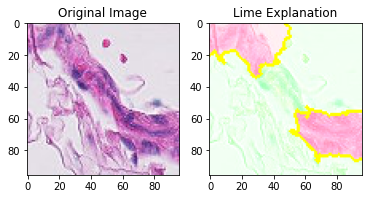

In [ ]:
#FP
Explain_Image_Lime(22,0)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


<Figure size 576x576 with 0 Axes>

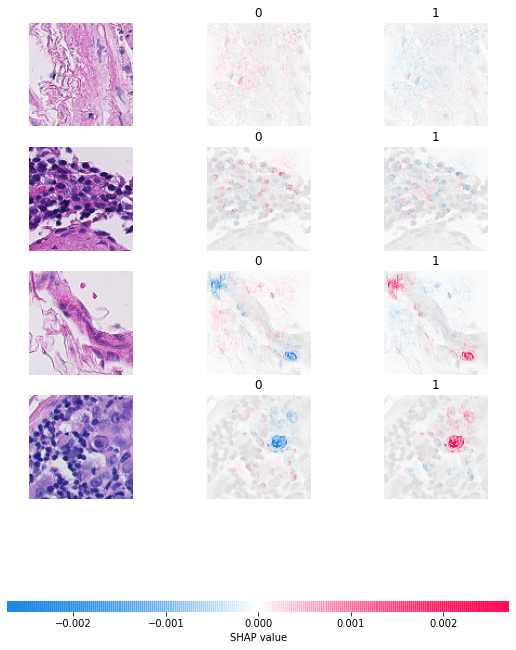

In [ ]:
######## Shap Explainer #############


background = X_train_shap

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(X_test_50[[2,15,22,26]])


# plot the feature attributions
plt.figure(figsize=(8,8))
shap.image_plot(shap_values, X_test_50[[2,15,22,26]], labels = [[str(0),str(1)]]*4)

Shap is based on Shapley values which corresponds to the importance of a feature computed by comparing what a model predicts with and without this feature.

DeepExplainer approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output.

In the example above, we use it on a background of 100 samples. We can then estimate the shap values of samples from the data test, here 4. What we could see, in the plot, is the 2 outputs of our model for each 4 test images.
The more blue the output is, the more the probability of this output will decrease. In contrary, the more red pixels are, the more the probability of this output will increase. The output 0 is for nonmetastatic class, 1 is for metastatic class.

# Gabor filtering

In this section, we use a texture-based approach to classifiy patches. Since the dataset is aroud 7Gb, we will only demonstrate the test phase and use pretrained model and preprocessed data.

The feature extraction with Gabor filters is time-consuming (from 10ms to 300ms per image). However, compared to CNNs, this method requires less data for the training phase; a training set of 2000 images leads to an accuracy of 76% with the full test dataset (32k images, ~2h40 of preprocessing without a GPU). Therefore, we can hypothesize that with further improvements, this method can be pretty convient in terms of deployability, *e.g*, if the scanner used to digitalize is different from the ones used for this challenge or if we want to detect slighty different types of tumor. 



<img src="https://drive.google.com/uc?id=1DXRAiZc4z8iNcjwVz3xCZc_aci6UHxNi"/>


Files to upload:
* utilitiesGabor.py
* Already processed images and labels



In [50]:
model_tuple = pickle.load(open('model16_AUC85.pkl',"rb"))

model = model_tuple[0]
stdScale = model_tuple[1]
pca_ = model_tuple[2]

X_train1 = np.load('X_train12000.npy')
y_train1 = np.load('y_train12000.npy')

X_test1 = np.load('X_test1Full.npy')
y_test1 = np.load('y_test1Full.npy')


Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomForestClassifier from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator StandardScaler from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator PCA from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.


## Feature extraction using Gabor filters
Energy of images filtered by Gabor filters is used to build a 16 or 32 features-input vector for our classification model. 

The first step for feature vector computing is to create the filter bank. We use two filter banks made of the same filters but at different scale ($9\times 9$ and $15\times 15$). Each bank is made of 16 filters.

In [51]:
import utilitiesGabor as gab

sigma = np.array([2])
sigma1 = np.array([5]) #deviation standard
theta = np.arange(4)*np.pi/4 #Orientation
lamba = np.array([5,10]) #Fréquence du sinus


filtBank9, nbFilt = gab.computeFilterBank(sigma,theta,lamba,[1],9)
filtBank15, nbFilt = gab.computeFilterBank(sigma1,theta,lamba,[2],15)


Number of filters in the bank :  8
Filter bank initialized
Number of filters in the bank :  8
Filter bank initialized


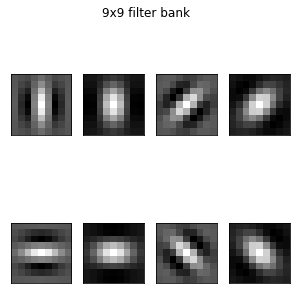

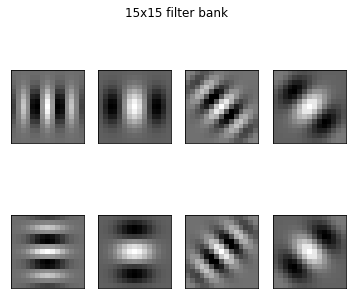

In [52]:
plt.figure(figsize=(5,5))
it=0
for k in range(2):
  for l in range(4):
    plt.subplot(2,4,it+1)
    plt.imshow(filtBank9[:,:,it],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    it+=1
plt.suptitle("9x9 filter bank")

plt.figure(figsize=(5,5))
it=0
for k in range(2):
  for l in range(4):
    plt.subplot(2,4,it+1)
    plt.imshow(filtBank15[:,:,it],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    it+=1
plt.suptitle("15x15 filter bank")
plt.tight_layout()
plt.show()

## Feature extraction and training


Once computed, filter banks are use to convolve images and create texture images using the `computeGaborEnergy` function.

We first convert images from the RGB space to grayscale, the texture information being still relevant after this operation. A positive image, i.e, label is equal to 1, means that a tumor is located in a centered patch of size $32\times 32$. 

We found that applying filterbanks on $45\times 45$ centered images increases the performance. We can suppose that this is due to the fact that tumor have a certain spatial context and it could interesting to look beyond the $32\times 32$ centered patch.

Finally, we use the `trainRBF` function to train a Random forest classifier. Several depth are tested and only the best is returned. We also return the *standard scaler* as well as the *pca* to transform future test data. 



```
coef9Train = gab.computeGaborEnergy(X_train,filtBank9,nbFilt)
coef15Train = gab.computeGaborEnergy(X_train,filtBank15,nbFilt)
X_train1 = np.concatenate((coef9Train,coef15Train),axis=1)

coef9Test = gab.computeGaborEnergy(X_test,filtBank9,nbFilt)
coef15Test = gab.computeGaborEnergy(X_test,filtBank15,nbFilt)
X_test1 = np.concatenate((coef9Test,coef15Test),axis=1)

y_train1 = np.zeros((X_train1.shape[0],))
for k in range(X_train1.shape[0]):
	y_train1[k] = y_train[k][0][0][0]


y_test1 = np.zeros((X_test1.shape[0],))
for k in range(X_test1.shape[0]):
	y_test1[k] = y_test[k][0][0][0]
```


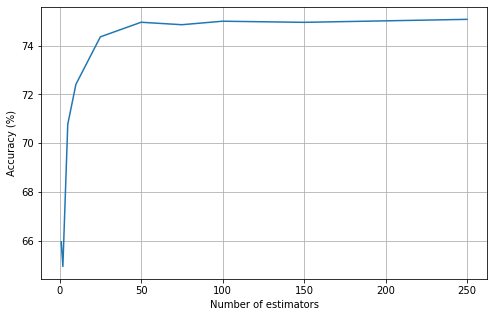

AUC = 0.8201214361412464
Best classifier (for 1000 images) depth =  250 , accuracy = 75.0762939453125 %
TP = 13009
TN = 11592
FP = 4799
FN = 3368


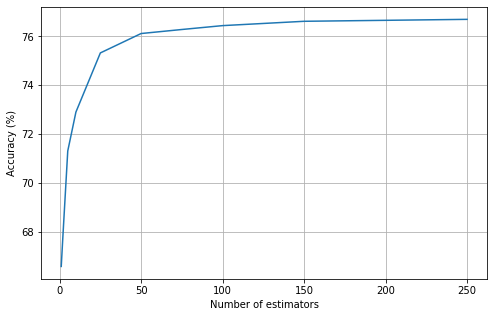

AUC = 0.8357100335873354
Best classifier (for 1000 images) depth =  250 , accuracy = 76.6937255859375 %
TP = 13539
TN = 11592
FP = 4799
FN = 2838


In [53]:
RFbest,stdScale = gab.trainRF(X_train1,X_test1,y_train1,y_test1)
RFbest,stdScale,pca = gab.trainRF(X_train1,X_test1,y_train1,y_test1,usePCA=True,nbPCA=16)

Attempt of classification using MLP (not very efficient)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Conv2DTranspose, Reshape, Dense, Activation, Flatten, Dropout, Convolution2D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(X_train1)

pca1 = PCA()
pca1.fit(X_train1)


Xtrain = scaler.transform(X_train1)
Xtest = scaler.transform(X_test1)
#Xtrain = pca1.transform(Xtrain)
#Xtest = pca1.transform(Xtest)

ytrain = np.asarray(y_train1).astype('float32').reshape((-1,1))
ytest = np.asarray(y_test1).astype('float32').reshape((-1,1))
#ytrain = tf.keras.utils.to_categorical(y_train1,2)
#ytest = tf.keras.utils.to_categorical(y_test1,2)

inputs = Input(shape=(16,1))
x = Dense(64,activation='relu')(inputs)
x = Dropout(rate=0.5)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(16,activation='relu')(x)
outputs = Dense(1,activation='sigmoid')(x)
m = Model(inputs,outputs)

lr = 0.1

sgd1 = tf.keras.optimizers.SGD(learning_rate=lr,momentum=0.5)
m.compile(optimizer=sgd1,loss="binary_crossentropy",metrics="accuracy")
history = m.fit(x=Xtrain,y=ytrain,batch_size=32,
                    epochs=10,verbose=1,validation_data=(Xtest,ytest))

Epoch 1/10
63/63 [==============================] - 3s 27ms/step - loss: 0.6694 - accuracy: 0.5875 - val_loss: 0.6473 - val_accuracy: 0.6401
Epoch 2/10
63/63 [==============================] - 1s 20ms/step - loss: 0.6585 - accuracy: 0.6204 - val_loss: 0.6449 - val_accuracy: 0.6390
Epoch 3/10
63/63 [==============================] - 1s 20ms/step - loss: 0.6555 - accuracy: 0.6302 - val_loss: 0.6329 - val_accuracy: 0.6525
Epoch 4/10
63/63 [==============================] - 1s 20ms/step - loss: 0.6544 - accuracy: 0.6280 - val_loss: 0.6463 - val_accuracy: 0.6378
Epoch 5/10
63/63 [==============================] - 1s 20ms/step - loss: 0.6560 - accuracy: 0.6218 - val_loss: 0.6459 - val_accuracy: 0.6387
Epoch 6/10
63/63 [==============================] - 1s 20ms/step - loss: 0.6467 - accuracy: 0.6406 - val_loss: 0.6359 - val_accuracy: 0.6505
Epoch 7/10
63/63 [==============================] - 1s 20ms/step - loss: 0.6494 - accuracy: 0.6369 - val_loss: 0.6350 - val_accuracy: 0.6511
Epoch 8/10
63

## Test and results

Once trained, the random forest is used to classify images from the test dataset.

The results goes as follow:
* Accuracy = 76%
* AUC = 0.83
* Sensitivity *(impact of FN)* = 0.82 
* Specifity *(impact of FP)* = 0.71

Accuracy = 0.76
AUC = 0.83
Sensitivity = 0.82
Specificity = 0.71
Confusion matrix : 
 [[11566  4825]
 [ 3002 13375]]


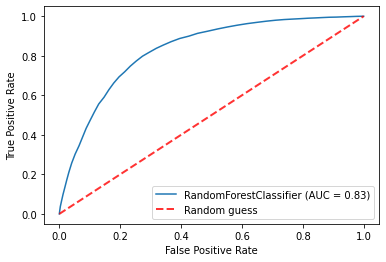

In [54]:
y_pred1 = gab.classifyRF(X_test1,stdScale,model,usePCA=True,pca_=pca_)
Xtest=stdScale.transform(X_test1)
Xtest=pca_.transform(Xtest)
report=classification_report(y_test1,y_pred1,output_dict=True)
print("Accuracy = {:.2f}".format(accuracy_score(y_test1,y_pred1)))
print("AUC = {:.2f}".format(roc_auc_score(y_test1,model.predict_proba(Xtest)[:,1])))
print("Sensitivity = {:.2f}".format(report["1.0"]["recall"]))
print("Specificity = {:.2f}".format(report["0.0"]["recall"]))
print("Confusion matrix : \n",confusion_matrix(y_test1,y_pred1))
plot_roc_curve(model,Xtest,y_test1)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random guess', alpha=.8)
plt.legend()
plt.show()

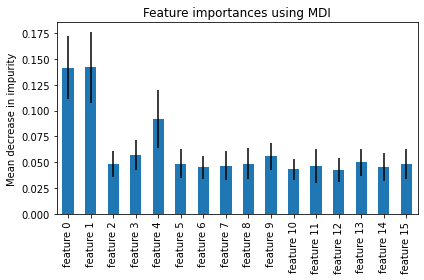

In [55]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
feature_names = [f'feature {i}' for i in range(X_test1.shape[1])]
import pandas as pd
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [56]:
dataExplainer = np.load('explainerData.npy',allow_pickle=True)

`dataExplainer` gathers few images which portray the behavior of the Gabor filters-based classifier in a meaningful way.	 

```
*[index=0] img 2 -> TN
*[index=1] img 3 -> TP but square and stripe do not match
*[index=2] img 9 -> FP global detection of tumor but no local detection
*[index=3] img 33 -> FN detection of a tumor in left stripe
*[index=4] img 34 -> FN detection of a tumor in left stripe and bottom left square
```

We use a homemade explainable tool to analyze the result produced by the Gabor-based model.

Given an input image `X`, two filterbanks ($9\times 9$ and $15\times 15$), trained model,scalers and labels, the function `explainer` displays :

* The original image
* Predictions in the four parts of the central square
* Predictions in the horizontal and vertical stripes

This is performed by classifying only one small part of the image (a half or a quarter).

This representation might be misleading as some couple of squares which are classified as *positive* may be classfied as *negative* when merged. Local prediction may also be *negative* on every subpart of the image and positive on the global scale.

Finally, the produced heatmap looks a bit coarsed because subscale analysis is limited to $15\times 15$ patches.  

Green = Tumor 	 Red = Normal 	 Gray = Background

Gabor coeficients computed
Process time = 0.33707846800007246
[0. 1. 1. 1. 0. 0. 1. 0.]
GT label : 1
Predicted : 1.0


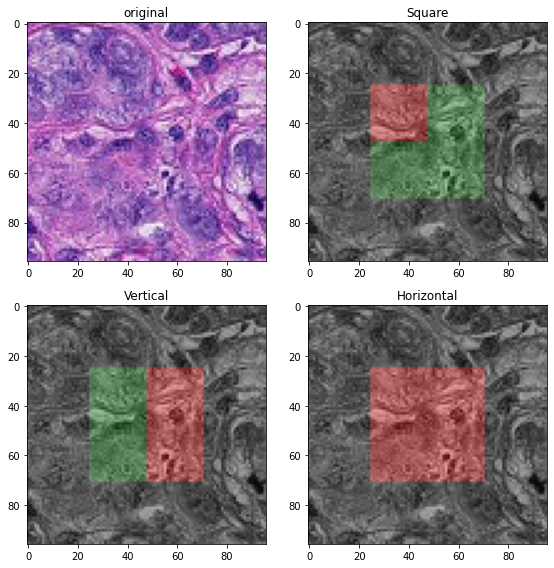

In [60]:
index = 1
img = np.array([dataExplainer[index][0]])
label = dataExplainer[index][1][0][0][0]
ind = dataExplainer[index][2]

print("Green = Tumor \t Red = Normal \t Gray = Background\n")
plt.figure(figsize=(8,8))
A = gab.explainer(img,[filtBank9,filtBank15],8,
			  model,stdScale,pca_,model.predict([Xtest[ind]])[0],label)
